In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import permutation
import math
import os

In [21]:
from sklearn.model_selection import cross_val_score, train_test_split 
#from sklearn.preprocessing import StandardScaler
#df=pd.read_csv('sisfall_3s_rad_pitch.csv')

df=pd.read_csv('sisfall_3s_rad_pitch_100Hz.csv')

#12维度 没有min
cols=['max_Ax','var_Ax','mean_Ax','max_Ay',
      'var_Ay','mean_Ay','max_Az','var_Az','mean_Az',
      'max_pitch','var_pitch','mean_pitch','label']


#16维度
# cols=['max_Ax','min_Ax','var_Ax','mean_Ax','max_Ay','min_Ay',
#       'var_Ay','mean_Ay','max_Az','min_Az','var_Az','mean_Az',
#       'max_pitch','min_pitch','var_pitch','mean_pitch','label']

df=df[cols]
y=df['label']
X=df.drop('label',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,random_state=42)

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
#定义模型 ： 多层感知机 MLP
model=models.Sequential()

#添加网络层，Dense（全连接层）：多层感知器的各个层都是全连接层。
model.add(layers.Dense( units=32,input_shape=(X_train.shape[1],)) )
model.add(layers.Dense( units=64,activation=tf.nn.sigmoid ))
# activation: 激活函数:sigmoid, relu,softmax,tanh,linear等
model.add(layers.Dense( units=32,activation=tf.nn.sigmoid) )
# output layer has 2 units (neurons) considering two categories: FALL/ADL          
model.add(layers.Dense(units=2, activation=tf.nn.sigmoid) )

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 4,674
Trainable params: 4,674
Non-trainable params: 0
_________________________________________________________________


In [26]:
# compile the model:编译模型
# 损失函数的选择：categorical_crossentropy，sparse_categorical_crossentropy．．．　　　optimizer：　adam，sgd
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback_list=[
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode='auto')
]

In [27]:
history = model.fit(
                    X_train, y_train, 
                    epochs=1000,batch_size=32, 
                    validation_data=(X_test,y_test),
                    callbacks=callback_list
                    ) 

Epoch 1/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.5011 - accuracy: 0.7508 - val_loss: 0.2761 - val_accuracy: 0.9333
Epoch 2/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.9450 - val_loss: 0.1670 - val_accuracy: 0.9411
Epoch 3/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1516 - accuracy: 0.9544 - val_loss: 0.1509 - val_accuracy: 0.9456
Epoch 4/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1375 - accuracy: 0.9594 - val_loss: 0.1253 - val_accuracy: 0.9622
Epoch 5/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9600 - val_loss: 0.1199 - val_accuracy: 0.9656
Epoch 6/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.9628 - val_loss: 0.1145 - val_accuracy: 0.9633
Epoch 7/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.9631 - val_loss: 0.1129 - val_accuracy:

In [29]:
TP=0
TN=0
FP=0
FN=0
Tr=0
for i in range(X_test.shape[0]):
    Input=X_test.values[i].reshape(1,-1)
    if model.predict(Input)[0][0]>model.predict(Input)[0][1]:
        y_pred=0
    else:
        y_pred=1
    if (y_test.values[i]==1) and (y_pred==1):
        TP+=1
        Tr+=1
    if (y_test.values[i]==1) and (y_pred==0):
        FN+=1
    if (y_test.values[i]==0) and (y_pred==1):
        FP+=1
    if (y_test.values[i]==0) and (y_pred==0):
        TN+=1
        Tr+=1
Sen=TP/(TP+FN)
Spe=TN/(TN+FP)
Auc=Tr/(X_test.shape[0])
print('Sen:',Sen)
print('Spe:',Spe)
print('Auc:',Auc)

Sen: 0.9607843137254902
Spe: 0.9760589318600368
Auc: 0.97


In [14]:
X_test.values[0]
#model.predict(Input)[0][1]

array([ 3.32031250e-01,  3.42058792e-04,  2.51881748e-01, -8.04687500e-01,
        6.87071334e-04, -9.38862645e-01,  2.77343750e-01,  2.16774130e-03,
        8.06166944e-02, -7.17831996e-01,  2.48216360e-02, -1.26951800e+00])

In [32]:
#查看输出结果
Input=X_train[-5:-4].values
model.predict(Input)  # 预测结果为 [为0的概率，为1的概率]

array([[2.6408677e-06, 9.9999738e-01]], dtype=float32)

In [33]:
Input=X_train[-5:-4].values
Input

array([[ 1.74225757,  4.3126759 ,  1.18751505, -0.36502314,  0.3359375 ,
         0.03226091, -0.5546875 ,  0.17961321,  0.3203125 ,  0.11067137]])

In [62]:
# Convert the model to the TensorFlow Lite format 
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()
# Save the model to disk
open('fall_detection_model_2.tflite', "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\11639\AppData\Local\Temp\tmprl_p64cu\assets


72444

In [108]:
def plot_acc(history, title='Model Accuracy'):
    plt.plot(history.history['accuracy'],label='accuracy')
    #plt.plot(history.history['val_acc'],label='val_acc')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.legend()
    plt.show()
    
def plot_loss(history, title='Model Loss'):
    plt.plot(history.history['loss'],label='loss')
    #plt.plot(history.history['val_loss'],label='val_loss')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    
    plt.legend()
    plt.show()

In [64]:
model.metrics_names

['loss', 'accuracy']

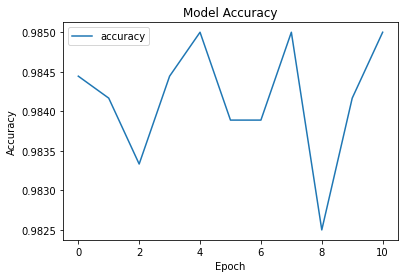

In [109]:
# Visualize results (using history for accuracy and loss)
plot_acc(history, 'Model Accuracy')

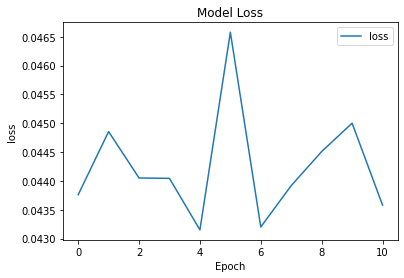

In [110]:
plot_loss(history, 'Model Loss')